In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from itertools import product

from matplotlib import colors

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform

In [1]:
map_kwargs = {
    'data_kwargs': {'grid_size': (7, 7), 'noise_std': 1},
    'transform_kwargs': {'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip': False},
    'data_dir': '../data/noise'
}

Found run_id vhgrhmcw


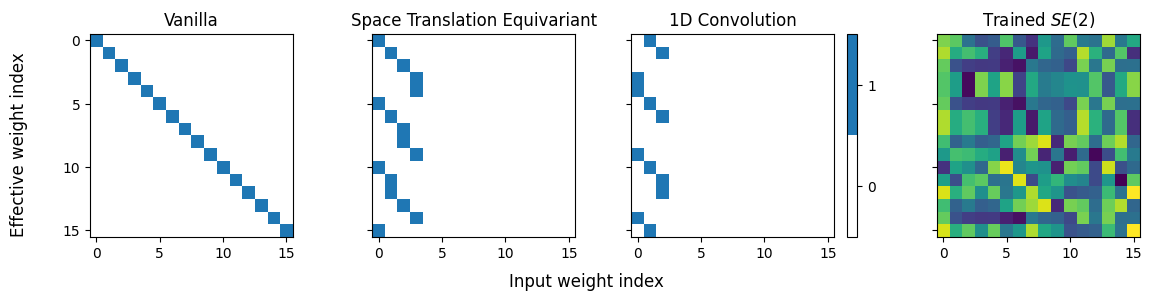

In [147]:
size_plot = 4
transform_funcs = {k: v() for k, v in CalculatedP(size = size_plot).transform_funcs.items()}

P_trained = get_and_check_Ps([1], map_kwargs, use_P_from_noise = True)[0, :size_plot**2, :size_plot**2]

Ps = ['none', 'space_translation', 'kernelconv']
title = {
    'none': 'Vanilla',
    'space_translation': 'Space Translation Equivariant',
    'kernelconv': '1D Convolution',
    'trained' : r'Trained $SE(2)$',
}


n_plots = len(Ps) + 1
fig, axs = plt.subplots(1, n_plots, figsize = (n_plots*3, 3), tight_layout = True, sharex=True,sharey=True)
cmap = colors.ListedColormap(['white', 'tab:blue'], N = 2)

for i, P in enumerate(Ps):
    ax = axs[i]
    im = ax.imshow(transform_funcs[P], cmap = cmap, interpolation="none", vmin = -0.5, vmax = 1.5)
    ax.set_title(title[P])
    ticks = np.linspace(0, size_plot**2-1, size_plot)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)


# Creat legend
cb = fig.colorbar(im, ax = ax, ticks = [0, 1])

ax = axs[-1]
ax.imshow(P_trained)#, cmap = cmap, interpolation="none", vmin = -0.5, vmax = 1.5)
ax.set_title(title['trained'])

# fig.suptitle(r'Weight mapping $P$')
fig.suptitle('')
fig.supxlabel('Input weight index')
fig.supylabel('Effective weight index')
fig.tight_layout()
plt.show()

savefig(fig, 'weight_mapping')

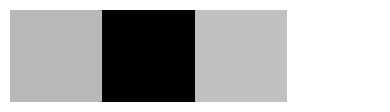

In [4]:
x = torch.randn((1,4))
size = x.shape[-1]
imshows([x], axis_off = True, imshow_kwargs={'cmap': 'gray'}, rows = False)

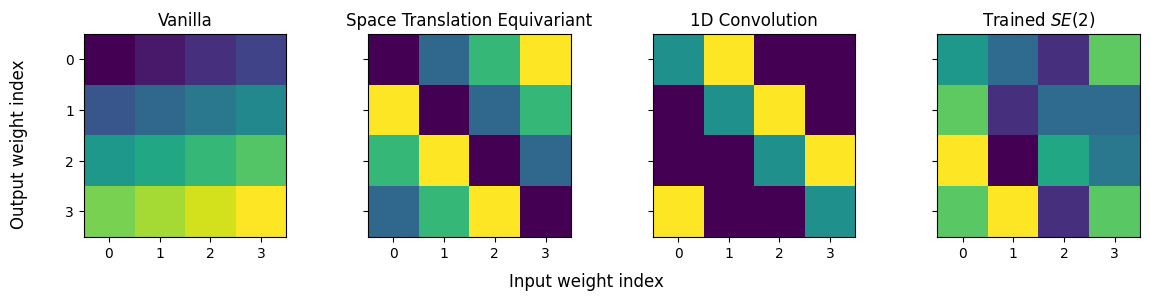

In [148]:
P_inits = ['none', 'space_translation', 'kernelconv', 'trained']

fig, axs = plt.subplots(1, len(P_inits), figsize = (len(P_inits)*3, 3), tight_layout = True, sharex=True, sharey=True)

for i, P_init in enumerate(P_inits):
    # Initialize linear layer with a specific weight mapping
    P_init_linearp = P_trained if P_init == 'trained' else P_init
    linear = LinearP(in_features=size, out_features=size, bias=False, P_init=P_init_linearp)

    # Initialize the weight matrix with custom values for easier plotting
    # This line can also be commented. Plot shows the same but less readable
    linear.weight.data = torch.arange(linear.out_features*linear.in_features).reshape(linear.out_features, linear.in_features).float()

    # Apply the weight mapping
    weight = (linear.P @ linear.weight.flatten()).reshape(linear.weight.shape)
    weight = weight.detach().numpy()

    ax = axs[i]

    ax.imshow(weight, cmap = 'viridis')
    ax.set_title(title[P_init])

    ticks = np.arange(size)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

# fig.suptitle(r'Effective weight matrix $(P \cdot W)$')
fig.suptitle('')
fig.supxlabel('Input weight index')
fig.supylabel('Output weight index')
fig.tight_layout()
plt.show()

savefig(fig, 'effective_weight_matrix')

### Checking conv

In [5]:
kernel_size = 3
conv = nn.Conv1d(
    in_channels  = 1, 
    out_channels = 1,
    kernel_size  = kernel_size,
    padding = 1,
    bias = False,
    padding_mode = 'circular',
)
out_conv = conv(x.unsqueeze(0)).squeeze(0)
out_conv


tensor([[-0.5689,  0.0994,  0.1208, -0.3750]], grad_fn=<SqueezeBackward1>)

In [7]:
# Initializing the custom linear layer with the mapping P for a convolutional kernel 
linear_conv = LinearP(in_features = size, out_features = size, bias = False, P_init = 'kernelconv')

# Setting the weights of the linear layer to be the same as the convolutional kernel
linear_conv.weight.data.flatten()[:kernel_size] = conv.weight.squeeze()

assert torch.allclose(linear_conv(x, normalize_P=False), out_conv)

# Presentation visuals

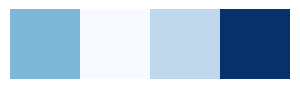

In [107]:
# showdataset = 'mnist'
showdataset = 'random'

match showdataset:
    case 'mnist':
        grid_size = (10, 10)
        features = np.prod(grid_size)

        data_dir = '../data'
        mnist_dir = os.path.join(data_dir, 'MNIST', 'val')
        x = np.load(os.path.join(mnist_dir, f'x_grid_size={grid_size}_noise_std=0.0_eps_mult=(0.0, 0.0, 0.0, 0.0)_only_flip=False.npy'))
        
        i = 0
        x = torch.from_numpy(x[i]).unsqueeze(0).float()

        subdir = 'stepa/mnist'
        l = 0.1

        transform = Transform(grid_size = grid_size, eps_mult = [0., 1., 1., 1.])
        centers = torch.tensor([0., 0.])

        x_a, _ = x_b, _ = x, _ = transform(x, centers, epsilons = torch.tensor([0., 0.25, -0.1, -0.1]))

        epsilons = torch.tensor([0., 0.25, -0.1, 0.0])


    case 'random':
        batch_size, features = 1, 4
        grid_size = (1, features)

        x_a = x_b = x = torch.tensor([[0.5, 0.25, 0.4, 0.8]]).float()

        subdir = 'stepa/random'
        l = 1

        transform = Transform(grid_size = grid_size, eps_mult = [0., 0., 1., 0.])

        epsilons = torch.tensor([0., 0.0, 0.5, 0.0])


    case _:
        raise ValueError(f'Unknown dataset {showdataset}')
    
def network_simple_imshow(
    x,    
    savename,
    l = l, 
    subdir = subdir,
    print_values = False, 
    cmap = 'Blues',
):
    fig = simple_imshow(x=x, l=l, print_values=print_values, imshow_kwargs={'cmap': cmap})
    
    savefig(fig, savename, subdir = subdir)

cmap1 = 'Blues'
cmap2 = 'Reds'

network_simple_imshow(x.reshape(grid_size), savename = 'x', cmap = cmap1)

In [108]:
linear = LinearP(in_features = features, out_features = features, bias = False, P_init = 'randn', train_P = True, train_weights=False)
linear.reset_parameters()
linear.eval()

print(f'{linear.weight.data.shape=}')
print(f'{linear.P.shape=}')

centers = torch.tensor([0., 0.])

linear.weight.data.shape=torch.Size([4, 4])
linear.P.shape=torch.Size([16, 16])


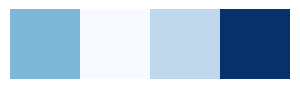

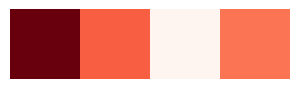

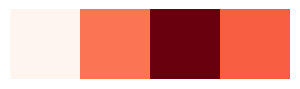

In [109]:
network_simple_imshow(x_a.reshape(grid_size), savename = 'x_a', cmap = cmap1)

out_a = linear(x_a).detach()
network_simple_imshow(out_a.reshape(grid_size), savename = 'o_a', cmap = cmap2)

out_a_prime, _ = transform(out_a, centers, epsilons)
network_simple_imshow(out_a_prime.reshape(grid_size), savename = 'o_a_prime', cmap = cmap2)

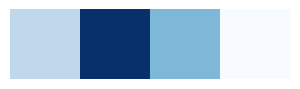

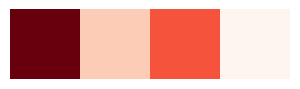

In [111]:
x_b_prime, _ = transform(x, centers, epsilons)
network_simple_imshow(x_b_prime.reshape(grid_size), savename = 'x_b_prime', cmap = cmap1)

out_b = linear(x_b_prime).detach()
network_simple_imshow(out_b.reshape(grid_size), savename = 'o_b', cmap = cmap2)
